In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms

import time
from keras.applications.inception_v3 import InceptionV3 , preprocess_input , decode_predictions

from keras.preprocessing import image
from keras.models import Model
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator


from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    losses = []
    accuracies = []
    test_accuracies = []

    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(train_loader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            output, aux_output = model(inputs)
            _, predicted = torch.max(output, 1)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [3]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (test_acc))
    return test_acc

In [6]:
train_img_path = '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train'
test_img_path = '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/test'

In [7]:
car_name_train = {}
for i in os.listdir(train_img_path):
    car_name_train[i] =  os.listdir(train_img_path+'/'+i)

In [21]:
#для InceptionV3
height = 299
width = 299

In [22]:
weight_path = '../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = InceptionV3(weights = weight_path , 
                         include_top = False, 
                         input_shape = (height , width , 3))

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    #shear_range=0.2,
    zoom_range=0.2,
    #fill_mode = 'constant',
    #cval = 1,
    rotation_range = 5,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [30]:
training_data = train_datagen.flow_from_directory(
    train_img_path,
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical')

test_data = test_datagen.flow_from_directory(
    test_img_path,
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical')

Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [23]:
'''
We start by freezing all of the base model’s layers.
We don’t want to train those layers since we are trying to leverage 
the knowledge learned by the network from the previous dataset (in this case ImageNet).
By setting the layer.trainable=False , 
we are telling Keras not to update those weights during training,
which is exactly what we want
'''
def built_finetune_model(base_model , fc_layers , n_classes):
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = Flatten()(x)
    
    for unit in fc_layers:
        x = Dense(units = unit , activation = 'relu')(x)
    
    predictions = Dense(n_classes , activation = 'softmax')(x)
    
    finetune_model = Model(inputs = base_model.input , outputs =  predictions)
    
    return finetune_model

In [24]:
n_classes = 196
fc_layers = [1050 , 500]

finetune_model = built_finetune_model(base_model , 
                                     fc_layers , 
                                     n_classes)

In [33]:
epochs = 15
batch_size = 64 
num_train_images = 8144

adam = Adam(lr = 0.00001)
finetune_model.compile(adam , loss = 'categorical_crossentropy',
                         metrics = ['accuracy'])

In [34]:
history = finetune_model.fit_generator(training_data , epochs = epochs , 
                                      workers = 8 , steps_per_epoch = num_train_images//batch_size ,
                                      shuffle = True)

/tmp/ipykernel_28/1216733953.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = finetune_model.fit_generator(training_data , epochs = epochs ,


Epoch 1/15
127/127 [==============================] - 180s 1s/step - loss: 2.5788 - accuracy: 0.3942
Epoch 2/15
127/127 [==============================] - 176s 1s/step - loss: 2.0295 - accuracy: 0.5186
Epoch 3/15
127/127 [==============================] - 176s 1s/step - loss: 1.6325 - accuracy: 0.6207
Epoch 4/15
127/127 [==============================] - 175s 1s/step - loss: 1.3327 - accuracy: 0.6934
Epoch 5/15
127/127 [==============================] - 176s 1s/step - loss: 1.0897 - accuracy: 0.7532
Epoch 6/15
127/127 [==============================] - 175s 1s/step - loss: 0.9074 - accuracy: 0.8093
Epoch 7/15
127/127 [==============================] - 175s 1s/step - loss: 0.7574 - accuracy: 0.8426
Epoch 8/15
127/127 [==============================] - 175s 1s/step - loss: 0.6256 - accuracy: 0.8762
Epoch 9/15
127/127 [==============================] - 175s 1s/step - loss: 0.5260 - accuracy: 0.9042
Epoch 10/15
127/127 [==============================] - 175s 1s/step - loss: 0.4548 - accura

In [35]:
def plot_loss(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epoch = range(len(loss))
    
    plt.style.use('fivethirtyeight')
    plt.figure(1 , figsize = (15 , 7))
    plt.subplot(1 , 2  , 1)
    plt.plot(epoch , loss, 'r-' , alpha = 0.5)
    plt.plot(epoch , loss, 'ro')
    plt.title('epoch vs loss')
    plt.subplot(1 , 2 , 2)
    plt.plot(epoch , acc, 'g-' , alpha = 0.5)
    plt.plot(epoch , acc, 'go')
    plt.title('epoch vs accuracy')
    plt.show()

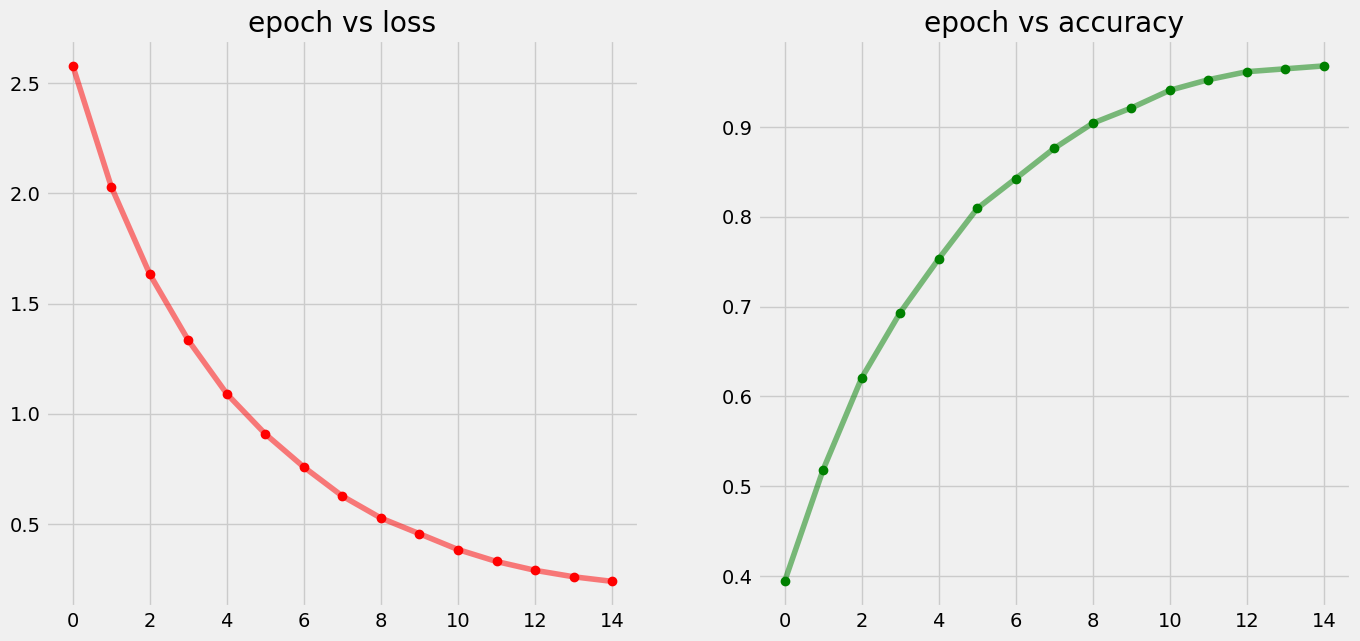

In [36]:
plot_loss(history)

In [37]:
scores = finetune_model.evaluate_generator(test_data)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

/tmp/ipykernel_28/2595593833.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = finetune_model.evaluate_generator(test_data)


Test Accuracy: 43.14%
